# VMC With SR -- Cleaned Debug View

In [1]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output
from math import exp
import time

from pdb import set_trace

## Helper Functions

In [2]:
# these are all the possible ground configurations that might
# contribute to the ground states

def get_random_state(num_particles):
    state = []
    positive_positions = random.sample(range(0, num_particles - 1), int(num_particles/2))
    for i in range(num_particles):
        if i in positive_positions:
            state.append(1)
        else:
            state.append(-1)
    return np.asarray(state)

In [3]:
def get_random_alpha(num_particles):
    assert num_particles %2 == 0, "Number of particles must be even"
    alpha = random.sample(range(1, 100), int(num_particles/2))
    alpha = np.asarray(alpha)
    alpha = alpha - 50
    alpha = alpha / 25
    return alpha

In [4]:
def get_off_diagonal_configurations(state):
    """
    This function generates a list of configurations that could
    be flipped into the inputted by state by the application of
    Raising or lowering operators (Check the hamiltonian equation)
    
    returns a list of configurations
    
    ***NOTE: This solution is computational intractable and might not
    be the most optimal one
    """
    state_copy = state.copy()
    off_diagonal_configurations = list()
    for i in range(len(state)):
        if i == len(state) - 1:
            if state[i] != state[0]:
                state_copy[i] *= -1
                state_copy[0] *= -1
                off_diagonal_configurations.append(state_copy)
            return off_diagonal_configurations
        if state[i] != state[i+1]:
            state_copy[i] *= -1
            state_copy[i+1] *= -1
            off_diagonal_configurations.append(state_copy)
            state_copy = state.copy()

In [5]:
def compute_R(trial_state, initial_state, alpha):
    """
    Function compute "R", which is the ratio between the weight functions
    of the initial state and the trial state.
    """
    numerator = get_variational_projection(trial_state, alpha) **2
    denominator = get_variational_projection(initial_state, alpha) **2
    if denominator < numerator:
        return 2.0
    return numerator / denominator

In [6]:
def random_flip(state):
    """
    Randomly flips two bits of a state such
    that there are still two up and two down
    """
    choices = random.sample(list(range(0,len(state))), len(state))
    flip1_index = choices.pop()
    flip1_value = state[flip1_index]
    state[flip1_index] *= -1
    cont = True
    while(cont):
        flip2_index = choices.pop()
        if state[flip2_index] != flip1_value:
            state[flip2_index] *= -1
            cont = False
    return state

## Functions for Finding Energies

In [7]:
def get_variational_projection(state, alpha):
    """
    The projection of input `state` onto the variational
    wave function. Ie: returns e^omega for the particular
    state
    N === number of particles
    Args:
    - state : N length np array of state represented as +1 or -1
    - alpha : N-1 length of np array of each variational parameter
    Return:
    - coeff (float)
    """
    try:
        num_particles = len(state)
        exponent = 0
        for idx, alpha in enumerate(alpha): # get all alphas assoicated with each distance r
            r = idx+1 # the distance is idx + 1 since idx is zero indexed
            for i in range(num_particles): #  iterate through all particles 0 - (num_particles-1)
                exponent += 0.25*alpha*state[i]*state[(i+r)%num_particles] # the % operator makes the loop work
        return exp(exponent)
    except OverflowError:
        print(f"Error: Overflow. State = {state}   alpha = {alpha}")
        return None

In [8]:
state = [1, -1 , 1, -1]
alpha = [0.5, -1]
get_variational_projection(state, alpha)

0.22313016014842982

In [9]:
def calculate_local_energy(state, alpha):
    """
    This function calculates the local energy of a state
    """
    num_particles = len(state)
    # print(f"State for calc local energy: {state}")
    # contribution from Z direction spin terms
    energy = 0
    state_proj = get_variational_projection(state, alpha)
    for i in range(len(state)):
        energy += (state_proj*state[i] * state[(i+1) % num_particles])/4
    diagonal_energies = energy
            
    # contributions from off diagonal terms
    non_diagonal_energies = 0
    off_diag_config_states = get_off_diagonal_configurations(state)
    for configuration in off_diag_config_states:
        non_diagonal_energies += (-0.5)*get_variational_projection(configuration, alpha)
    energy += non_diagonal_energies
    
    if do_print:
        print(f"Non-diag config: {off_diag_config_states}")
        print(f"Diag Energy: {diagonal_energies}")
        print(f"Non Diag energies: {non_diagonal_energies}")
    
    
    return energy / state_proj

In [10]:
def monte_carlo_estimation(alpha, num_steps, num_particles):
    """
    This function calculates expectation values for the 
    4 variables of interest P, Q, 
    """
    # only works for even number of particles
    assert num_particles %2 == 0, "Number of particles must be even"

    x_initial = get_random_state(num_particles)

    # initialize running variables
    expectation_local_energy = 0
    expection_delta = 0
    expectation_P = 0
    expectation_Q =0
    
    for i in range(num_steps):
        clear_output(wait=True)
        if False:
            if i % 500 == 0:
                print(f"Alpha: {alpha[0]} -- Step: {i+1}/{num_steps}")
        x_trial = random_flip(x_initial.copy())
        R = compute_R(x_trial, x_initial, alpha)
        r = random.uniform(0,1)
        if R > r:
            x_initial = x_trial.copy()
        # these "expectation" variables are running totals of the variables/arrays/matrixes.
        # they represent the sum of all the values for all the trial state inputs (x)
        # and will be normalized by dividing by the number of steps after the simulation
        delta_x = calculate_delta_x(x_initial, alpha)
        local_energy = calculate_local_energy(x_initial, alpha)
        P_of_x = calculate_P_of_x(delta_x)
        Q_of_x = calculate_Q_of_x(delta_x, local_energy)

        if do_print:
            print(f"Alpha: {alpha}")
            print(f"State input: {x_initial}")
            print(f"Local Energy: {local_energy}")
            print(f"P(x) = {P_of_x}")
            print(f"Q(x) = {Q_of_x}")
            print(f"delta(x) = {delta_x}")
            
        if debug:
            time.sleep(5)
        
        expectation_local_energy += local_energy
        expection_delta += delta_x
        expectation_P += P_of_x
        expectation_Q += Q_of_x
    # normalize expectation values
    expectation_local_energy = expectation_local_energy / num_steps
    expectation_delta = expection_delta / num_steps
    expectation_P = expectation_P / num_steps
    expectation_Q = expectation_Q / num_steps
    return expectation_local_energy, expectation_delta, expectation_P, expectation_Q

## SR Functions

In [11]:
def update_variational_parameters(alpha, exp_local_energy, exp_delta, exp_P, exp_Q, lr=0.03, d_alpha_cap = 0.1):
    """
    This function applies the SR technique.
    """
    
    # cap the change in alpha
    d_alpha_cap = d_alpha_cap
    
    # contruction the f vector
    f = exp_Q - exp_delta*exp_local_energy
    
    
    # constructing the S matrix
    temp1 = np.expand_dims(exp_delta, axis=0)
    temp1 = np.repeat(temp1, len(exp_delta), axis=0)
    temp2 = temp1.T
    temp3 = np.multiply(temp1, temp2)
    S = exp_P - temp3
    identity = np.eye(len(S[0]), len(S[0]))
    inverse_S = np.linalg.lstsq(S, identity)[0]
    
    if do_print:
        print(f"f vector = {f}")
        print(f"S Matrix = {S}")
    
    # perform the updates
    try:
        d_alpha = lr*np.matmul(inverse_S, f)
    except:
        print(f"Linalg error")
        print(f"f vector = {f}")
        print(f"S Matrix = {S}")
        time.sleep(5)
    
    # cap the changes in each parameter
    print(f"Current alpha: {alpha}")
    print(f"D_alpha BEFORE: {d_alpha}")
    for i, param in enumerate(d_alpha):
        if param > d_alpha_cap:
            d_alpha[i] = d_alpha_cap
        elif param < -1*d_alpha_cap:
            d_alpha[i] = -1*d_alpha_cap
    print(f"d_alpha_cap {d_alpha_cap}")
    print(f"parame {param}")
    print(f"d alpha after: {d_alpha}")
            
    alpha = alpha - d_alpha
    print(f"Next alpha: {alpha}")
    return alpha

In [12]:
# functions to calculate variables of interest
# with a given state as input
# expection values will be calcualate by averaging
# these functions over many states

# this are intermediate variables defined in my
# physical notebook

def calculate_delta_x(state, alpha):
    """
    This function gives the delta vector for a particular
    state. The delta vector is a vector with the derivative
    of the wave function with respect to the particular
    indexed paramater. The len the vector is the 
    number of particles - 1 which the number of 
    variational paramters.
    args:
    state - number array length N
    return:
    - delta_x : array length N-1 fo derivatives
    """
    num_particles = len(state)
    delta = np.zeros(len(alpha))
    for idx in range(len(delta)): # for each idx in our delta matrix
        r = idx + 1          # is 1 greater than idx since idx is zero-indexed
        for i in range(num_particles):
            delta[idx] += 0.25*state[i]*state[(i+r)%num_particles]
    
    return delta

def calculate_P_of_x(delta_x):
    """
    Args:
    delta_x : array outputted by the calculate_delta_x function
    returns:
    - matrix of size delta_x by delta_x where 
    value(i,j) = delta_x[i]*delta_x[j]
    """
    temp1 = np.expand_dims(delta_x, axis=0)
    temp1 = np.repeat(temp1, len(delta_x), axis=0)
    temp2 = temp1.T
    return np.multiply(temp1, temp2)

def calculate_Q_of_x(delta_x, local_energy):
    return local_energy*delta_x

## Main function for SR

In [13]:
def run_stochastic_reconfiguration(num_steps, num_particles, lr, d_alpha_cap):
    show_plot = not do_print
    
    alpha = get_random_alpha(num_particles)
    
    # get inital condition
    alphas = [] # list of all alphas that we test
    alpha1s = []
    alpha2s = []
    energies = [] # list of all energies corresponding to those alphas
    
    # pre loop conditions
    cont = True
    min_energy = 99999999999
    latest_energy = min_energy
    energy = latest_energy
    time_caught_in_local_min = 0
    loop_count = 0
    
    reset_count = 0 # the number of times the alpha was randomly initialized
    
    while(cont):
        try:
            clear_output(wait=True)
            
            if not show_plot:
                if loop_count % 1 == 0:
                    print(f"""Optimal Energy: %3.2f 
                    \nCurrent Energy: %3.2f 
                    \nloop count: %i
                    \nCurrent Alpha: {alpha}
                    """ % (min_energy, energy, loop_count))
            alphas.append(alpha)
            alpha1s.append(alpha[0])
            alpha2s.append(alpha[1])

            energy, exp_delta, exp_P, exp_Q = monte_carlo_estimation(alpha, num_steps, num_particles)
            energies.append(energy)
            
            if show_plot:
                plt.plot(alpha1s, energies)
                plt.plot(alpha2s, energies)
                plt.xlabel("Alphas")
                plt.ylabel("Variational Energy")
                plt.title("Energies -- Alphas")
                plt.show()
                time.sleep(delay)
            # if this energy is lowest, update optimal measurements,
            # and assume you can do better (set end count, i, to zero)
            if energy < (latest_energy - 0.02):
                time_caught_in_local_min = 0
                loop_count = 0
                if energy < min_energy:
                    min_energy = energy
                    opt_alpha = alpha
            # if not, inncrement the end count. If you don't get better
            # after 400 tries, it's probably time to stop
            else:
                """
                time_caught_in_local_min += 1
                if time_caught_in_local_min == 10:
                    if reset_count == 4:
                        cont = False
                    alpha = get_random_alpha(num_particles)
                    reset_count += 1
                """
                loop_count += 1
                if loop_count == 20:
                    cont = False
                    
            latest_energy = energy


            alpha = update_variational_parameters(alpha, energy, exp_delta, exp_P, exp_Q, lr, d_alpha_cap)

            loop_count += 1
        except KeyboardInterrupt:
            cont = False
        
    print(f"Optimal Alpha: {opt_alpha}" )
    print("Optimal Energy: %3.2f" % min_energy)

    return opt_alpha, min_energy, alphas, energies

## Debugging Console

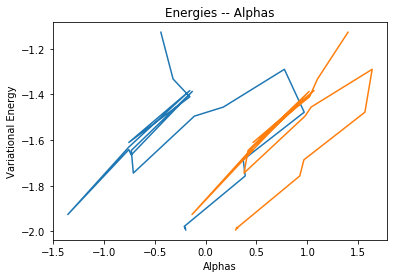

CUrrent alpha: [-0.19553779  0.29607557]
D_alpha BEFORE: [-0.00173112  0.00346224]
d_alpha_cap 0.6
parame 0.0034622440537651236
d alpha after: [-0.00173112  0.00346224]
Next alpha: [-0.19380666  0.29261333]
Optimal Alpha: [-0.21043546  0.32587093]
Optimal Energy: -1.98


(array([-0.21043546,  0.32587093]),
 -1.9787930026272993,
 [array([-0.44,  1.4 ]),
  array([-0.32,  1.1 ]),
  array([-0.155  ,  1.02125]),
  array([-0.755  ,  0.46625]),
  array([-0.155  ,  1.06625]),
  array([-0.755  ,  0.46625]),
  array([-1.355  , -0.13375]),
  array([-0.755  ,  0.46625]),
  array([-0.73078408,  0.41781817]),
  array([-0.13078408,  1.01781817]),
  array([-0.73078408,  0.41781817]),
  array([-0.71055274,  0.37735548]),
  array([-0.11055274,  0.97735548]),
  array([0.17444726, 1.03735548]),
  array([0.77444726, 1.63735548]),
  array([0.96944726, 1.56610548]),
  array([0.36944726, 0.96610548]),
  array([0.38956454, 0.92587093]),
  array([-0.21043546,  0.32587093]),
  array([-0.2072925 ,  0.31958499]),
  array([-0.20445134,  0.31390268]),
  array([-0.20188114,  0.30876228]),
  array([-0.19955455,  0.30410911]),
  array([-0.19744731,  0.29989462]),
  array([-0.19553779,  0.29607557])],
 [-1.127238578112315,
  -1.3321879107403796,
  -1.4104447241117495,
  -1.6105075728841

In [15]:
do_print = False
debug = False
delay = 0
D_ALPHA_CAP = 0.6
lr = 0.03
run_stochastic_reconfiguration(5000, 4, lr, D_ALPHA_CAP)